In [75]:
from bs4 import BeautifulSoup
import requests
import re
import json
import time
import random
import os
from collections import defaultdict
import dateutil.parser
from datetime import datetime
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sns.set()

# Steps
- Examine and explore the data   
  - Look at the data. If you can examine all of it in detail that is ideal. If dataset is very large, this may be unwieldy, so look at all of data in aggregated form (what is data type, how many entries are there, etc.) and examine a random subset in detail. Make sure the data is clean (remove NaN, for example) and meaningful (e.g., if the number of customers is negative, there is a problem).
     
  - Look at statistics: Correlation matrix, seaborn plots (to check for colinearity; compare what you see with human intuition) and probability distributions. Linear regression will typically see more success if the target variable has a fairly symmetric distribution (e.g., it might look close to a normal distribution). Look at the residual vs. y_pred plot for any weirdness (for example, due to bimodal distribution). 
  
- Baselining. Look at one feature (you might get lucky and this is THE feature needed to explain your observations). You can see the fit immediately from the seaborn plot. Run statsmodels or sklearn to look at R^2, etc.
- Expand model. Run it with a few features (3 or 4), so it is still humanly interpretable. Plot distribution of target variable, errors vs. predicted value to see if non-linearity or heteroskedasticity are an issue. Check fit of the model. Possibly run statsmodels to calculate p-values and see if they correspond to your intuition.
- Complete model. Run with all features and run same diagnostics. Do you need all of the features or can you discard some of them? Are the coefficients (betas) statistically significant? Make sure you understand the diagnostics to know if your p-values are trustworthy or not.
- Validate model. Set up a validation scheme, preferably cross-validation if you have the computational resources as it is more robust. Using your validation scheme, you can perform iterative feature selection/expansion/engineering and model complexity adjustments in order to complete the next 2 steps.
- Challenge model. Do you need more complexity or less? Do you need a fancier model (nonlinear, additional feature engineering / transformations e.g. polynomial)? Hopefully at this point you have an understanding of where you need to go by knowing the bias vs. variance tradeoff.
- Refine model. Add or remove complexity (using a more sophisticated model or making your model more conservative by using regularization). Compare with unrefined model (error vs. y_pred, R^2, MAE, RMSE). Use regularization to fine tune model (Ridge, Lasso; Lasso may eliminate coefficients that you included at first).
- Test model. How does your final, refined model perform on out-of-sample data? If it does well, hurray! If not, linear regression (with this data set) may not be the answer and you have to move to find more features, more data, or more complex models that are harder to interpret.



In [140]:
def model(X, y, one_x=False):
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.25)

    #
    # Linear
    # score on train to get upper bound
    lm1 = LinearRegression()
    lm1.fit(X_cv, y_cv)
    print("Best possible Linear Regression R^2:", lm1.score(X_cv, y_cv))

    lm2 = LinearRegression()
    cv_scores = cross_val_score(lm2, X_cv, y_cv, # estimator, features, target
                                  cv=5, # number of folds 
                                  scoring='r2') # scoring metric
    print('K-Fold CV Linear Regression R^2:',  cv_scores, "mean: ", np.mean(cv_scores))
    
    #lm2.fit(X_cv,y_cv)
    #print(f'Linear Regression test R^2: {lm2.score(X_test, y_test):.3f}')
    
    if one_x:
        return
    #
    #
    # Ridge
    #Feature scaling for train, val, and test so that we can run our ridge model on each
    scaler = StandardScaler()

    X_cv_scaled = scaler.fit_transform(X_cv.values)
    X_test_scaled = scaler.transform(X_test.values)

    lm_reg1 = Ridge(alpha=1)
    lm_reg1.fit(X_cv_scaled, y_cv)
    print("Best possible Ridge Regression R^2:", lm_reg1.score(X_cv_scaled, y_cv))
    
    lm_reg2 = Ridge(alpha=1)
    cv_scores = cross_val_score(lm_reg2, X_cv_scaled, y_cv, cv=5, scoring='r2')
    print('K-fold CV Ridge Regression R^2: ',  cv_scores, "mean: ", np.mean(cv_scores)) 
    
    #lm_reg2.fit(X_cv_scaled,y_cv)
    #print(f'Polynomial Regression test R^2: {lm_reg2.score(X_test_scaled, y_test):.3f}')
    

    #
    #
    # Poly
    poly = PolynomialFeatures(degree=2) 

    X_cv_poly = poly.fit_transform(X_cv.values)
    X_test_poly = poly.transform(X_test.values)

    lm_poly1 = LinearRegression()
    lm_poly1.fit(X_cv_poly, y_cv)
    print("Best possible Polynomial Regression R^2:", lm_poly1.score(X_cv_poly, y_cv))
    
    lm_poly2 = LinearRegression()
    cv_scores =  np.mean(cross_val_score(lm_poly2, X_cv_poly, y_cv, cv=5, scoring='r2')) 
    print('K-fold CV Polynomial Regression R^2: ',  cv_scores, "mean: ", np.mean(cv_scores)) 
    
    #lm_poly2.fit(X_cv_poly,y_cv)
    #print(f'Polynomial Regression test R^2: {lm_poly2.score(X_test_poly, y_test):.3f}')
    
    return (lm2, lm_reg2, lm_poly2)


In [146]:
df = pd.read_pickle('../resources/pickles/kickstarter_cat_34.pkl')

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11607 entries, 0 to 11606
Data columns (total 33 columns):
backers_count               11607 non-null int64
base_id                     11607 non-null int64
blurb                       11607 non-null object
category_id                 11607 non-null int64
category_parent_id          11607 non-null int64
category_slug               11607 non-null object
converted_pledged_amount    11607 non-null int64
country                     11607 non-null object
created_at                  11607 non-null datetime64[ns]
creator_id                  11607 non-null int64
creator_url                 11607 non-null object
deadline                    11607 non-null datetime64[ns]
fx_rate                     11607 non-null float64
goal                        11607 non-null float64
is_flagged_spotlight        11607 non-null bool
launched_at                 11607 non-null datetime64[ns]
location_country            11604 non-null object
location_id            

In [148]:
df.drop_duplicates(inplace=True, subset='profile_project_id')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10563 entries, 0 to 11606
Data columns (total 33 columns):
backers_count               10563 non-null int64
base_id                     10563 non-null int64
blurb                       10563 non-null object
category_id                 10563 non-null int64
category_parent_id          10563 non-null int64
category_slug               10563 non-null object
converted_pledged_amount    10563 non-null int64
country                     10563 non-null object
created_at                  10563 non-null datetime64[ns]
creator_id                  10563 non-null int64
creator_url                 10563 non-null object
deadline                    10563 non-null datetime64[ns]
fx_rate                     10563 non-null float64
goal                        10563 non-null float64
is_flagged_spotlight        10563 non-null bool
launched_at                 10563 non-null datetime64[ns]
location_country            10560 non-null object
location_id            

In [82]:
df.describe()

,backers_count,base_id,category_id,category_parent_id,converted_pledged_amount,creator_id,fx_rate,goal,location_id,percent_funded,pledged,profile_project_id,usd_pledged
count,10563.000000,1.056300e+04,10563.0,10563.0,1.056300e+04,1.056300e+04,10563.000000,1.056300e+04,1.056000e+04,1.056300e+04,1.056300e+04,1.056300e+04,1.056300e+04
mean,865.605699,1.073541e+09,34.0,12.0,6.746052e+04,1.079246e+09,1.002523,1.243621e+04,2.797428e+06,2.275317e+03,7.436373e+04,2.700932e+06,6.751367e+04
std,3229.067558,6.216240e+08,0.0,0.0,2.945993e+05,6.232037e+08,0.174899,4.469103e+04,5.037582e+06,4.640750e+04,3.161897e+05,9.339071e+05,2.948168e+05
min,1.000000,3.923500e+04,34.0,12.0,8.000000e+00,4.223010e+05,0.009313,1.000000e+00,3.210000e+02,1.000000e+02,8.000000e+00,1.484000e+03,8.000000e+00
25%,96.000000,5.299131e+08,34.0,12.0,4.003000e+03,5.458201e+08,1.000000,1.000000e+03,7.790630e+05,1.516750e+02,4.002770e+03,2.216520e+06,4.009899e+03
50%,252.000000,1.083914e+09,34.0,12.0,1.242200e+04,1.081689e+09,1.000000,5.000000e+03,2.401184e+06,2.985000e+02,1.242700e+04,2.975688e+06,1.242700e+04
75%,720.000000,1.610657e+09,34.0,12.0,3.776250e+04,1.620165e+09,1.000000,1.241350e+04,2.473224e+06,6.942050e+02,3.956375e+04,3.423805e+06,3.792578e+04
max,219382.000000,2.147389e+09,34.0,12.0,1.239314e+07,2.146601e+09,1.229370,2.200000e+06,5.604400e+07,3.284300e+06,1.239314e+07,3.819693e+06,1.239314e+07


In [83]:
df.head()

,backers_count,base_id,blurb,category_id,category_parent_id,category_slug,converted_pledged_amount,country,created_at,creator_id,creator_url,deadline,fx_rate,goal,is_flagged_spotlight,launched_at,location_country,location_id,location_name,name,percent_funded,pledged,profile_external_url,profile_project_id,profile_state,profile_state_changed_at,slug,staff_pick,state,state_changed_at,url_project,url_rewards,usd_pledged
0,181,592551458,More High Fantasy inspired soundscapes for gam...,34,12,games/tabletop games,6734,US,2014-02-21 02:35:10,1766442648,https://www.kickstarter.com/profile/strangelette,2014-11-22 19:36:51,1.00000,1000.0,True,2014-10-23 18:36:51,United States,2466256.0,"Orlando, FL",Epic Fantasy Soundtracks II: Tabletop Gaming S...,673.400000,6734.0,None,899458,inactive,2015-03-09 15:44:09,epic-fantasy-soundtracks-ii-tabletop-gaming-so...,False,successful,2014-11-22 19:36:52,https://www.kickstarter.com/projects/strangele...,https://www.kickstarter.com/projects/strangele...,6734.000000
1,147,1573096498,A card game of deduction and dirty tricks for ...,34,12,games/tabletop games,3347,US,2014-10-17 13:32:54,256517189,https://www.kickstarter.com/profile/256517189,2014-11-19 19:00:00,1.00000,1000.0,True,2014-10-28 14:10:48,United States,2396300.0,"East Walpole, MA",Truths Too Terrible,334.700000,3347.0,http://www.amazon.com/gp/product/B00UZLJ6LS,1447772,active,2015-03-23 17:37:55,truths-too-terrible,False,successful,2014-11-19 19:00:12,https://www.kickstarter.com/projects/256517189...,https://www.kickstarter.com/projects/256517189...,3347.000000
2,24,733303305,"The next unit in my Orc range, this time the B...",34,12,games/tabletop games,1440,GB,2014-10-13 09:54:06,231062375,https://www.kickstarter.com/profile/231062375,2014-11-18 08:57:18,1.22937,600.0,True,2014-10-19 07:57:18,United Kingdom,12695981.0,"Stevenage Borough, UK",Orc Bowmen 28mm miniatures,153.333333,920.0,None,1435632,inactive,2015-03-09 15:44:39,orc-bowmen-28mm-miniatures,False,successful,2014-11-18 08:57:19,https://www.kickstarter.com/projects/231062375...,https://www.kickstarter.com/projects/231062375...,1480.489723
3,67,365147754,Resin wargaming models scaled to fit with 28 t...,34,12,games/tabletop games,4430,GB,2014-10-29 08:58:26,179741323,https://www.kickstarter.com/profile/179741323,2014-11-13 15:43:08,1.22937,500.0,True,2014-10-29 14:43:08,United Kingdom,30720.0,"Nottingham, UK",Minimus Squat's Bounty Hunter Crew,561.800000,2809.0,None,1476869,inactive,2015-03-09 15:44:41,minimus-squats-bounty-hunter-crew,False,successful,2014-11-13 15:43:08,https://www.kickstarter.com/projects/179741323...,https://www.kickstarter.com/projects/179741323...,4530.506324
4,247,654422435,d&D sucks and this is the GREATEst game of ALL...,34,12,games/tabletop games,1824,US,2014-08-23 04:25:19,1430411066,https://www.kickstarter.com/profile/1430411066,2014-11-12 20:01:00,1.00000,50.0,True,2014-10-08 17:35:17,United States,2490383.0,"Seattle, WA",50 sHAdes of VORpal,3648.000000,1824.0,http://www.drivethrurpg.com/product/211137/50-...,1310498,active,2017-05-05 07:46:07,50-shades-of-vorpal,True,successful,2014-11-12 20:01:00,https://www.kickstarter.com/projects/143041106...,https://www.kickstarter.com/projects/143041106...,1824.000000


- Examine and explore the data   
  - Look at the data. If you can examine all of it in detail that is ideal. If dataset is very large, this may be unwieldy, so look at all of data in aggregated form (what is data type, how many entries are there, etc.) and examine a random subset in detail. Make sure the data is clean (remove NaN, for example) and meaningful (e.g., if the number of customers is negative, there is a problem).
     
  - Look at statistics: Correlation matrix, seaborn plots (to check for colinearity; compare what you see with human intuition) and probability distributions. Linear regression will typically see more success if the target variable has a fairly symmetric distribution (e.g., it might look close to a normal distribution). Look at the residual vs. y_pred plot for any weirdness (for example, due to bimodal distribution). 
  

# Baselining
Look at one feature (you might get lucky and this is THE feature needed to explain your observations). You can see the fit immediately from the seaborn plot. Run statsmodels or sklearn to look at R^2, etc.

In [150]:
ks_df = df[[
    'profile_project_id',
    'backers_count',   
    'usd_pledged'
   ]].dropna()
ks_df.sample(20)

,profile_project_id,backers_count,usd_pledged
3463,3387327,382,8305.437467
6851,3382955,2246,43604.580410
9421,1056224,990,84466.000000
5118,3451307,423,14726.840000
7817,3338287,1486,52203.000000
8060,570698,597,23267.250000
10973,2027085,1512,105673.000000
2526,3249485,550,5550.000000
673,3478158,3327,103181.000000
5996,3681556,103,6198.544897


In [151]:
ks_df.describe()

,profile_project_id,backers_count,usd_pledged
count,1.056300e+04,10563.000000,1.056300e+04
mean,2.700932e+06,865.605699,6.751367e+04
std,9.339071e+05,3229.067558,2.948168e+05
min,1.484000e+03,1.000000,8.000000e+00
25%,2.216520e+06,96.000000,4.009899e+03
50%,2.975688e+06,252.000000,1.242700e+04
75%,3.423805e+06,720.000000,3.792578e+04
max,3.819693e+06,219382.000000,1.239314e+07


In [152]:
ks_df.drop('profile_project_id', axis =1).corr()

,backers_count,usd_pledged
backers_count,1.000000,0.738528
usd_pledged,0.738528,1.000000


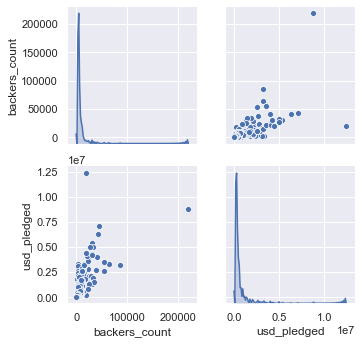

In [153]:
sns.pairplot(ks_df.drop('profile_project_id', axis =1), diag_kind='kde')

## Extreme dollars raised

In [154]:
ks_df.sort_values('usd_pledged', ascending=False)

,profile_project_id,backers_count,usd_pledged
3146,2752819,19264,1.239314e+07
6518,1577596,219382,8.782572e+06
2163,3134570,43733,7.072757e+06
862,3510927,41939,6.297405e+06
5783,1982424,31178,5.342789e+06
10402,3010038,27236,5.004615e+06
10339,3717678,32582,4.995435e+06
10394,3244557,19303,4.403198e+06
2161,3194341,30553,4.248834e+06
10404,2892230,31262,4.228060e+06


In [155]:
df.loc[df['profile_project_id']==2752819]

,backers_count,base_id,blurb,category_id,category_parent_id,category_slug,converted_pledged_amount,country,created_at,creator_id,creator_url,deadline,fx_rate,goal,is_flagged_spotlight,launched_at,location_country,location_id,location_name,name,percent_funded,pledged,profile_external_url,profile_project_id,profile_state,profile_state_changed_at,slug,staff_pick,state,state_changed_at,url_project,url_rewards,usd_pledged
3146,19264,545070200,A cooperative nightmare horror game experience...,34,12,games/tabletop games,12393139,US,2016-11-09 16:16:44,2121023188,https://www.kickstarter.com/profile/poots,2017-01-07 23:00:00,1.0,100000.0,True,2016-11-25 05:01:41,United States,2411081.0,"Glendale, NY",Kingdom Death: Monster 1.5,12393.13969,12393139.69,https://shop.kingdomdeath.com/collections/in-s...,2752819,active,2017-01-09 21:29:48,kingdom-death-monster-15,True,successful,2017-01-07 23:00:03,https://www.kickstarter.com/projects/poots/kin...,https://www.kickstarter.com/projects/poots/kin...,12393139.69


## Extreme number of backers

In [156]:
ks_df.sort_values('backers_count', ascending=False)

,profile_project_id,backers_count,usd_pledged
6518,1577596,219382,8.782572e+06
5778,2712207,85581,3.215680e+06
5787,2334346,63758,3.246589e+06
10340,3743270,55024,3.538065e+06
859,3524769,53643,2.559458e+06
2163,3134570,43733,7.072757e+06
862,3510927,41939,6.297405e+06
3144,2921056,40642,3.999796e+06
2152,3409738,38335,2.650876e+06
6509,2122342,34565,1.479047e+06


In [157]:
df.loc[df['profile_project_id']==1577596]

,backers_count,base_id,blurb,category_id,category_parent_id,category_slug,converted_pledged_amount,country,created_at,creator_id,creator_url,deadline,fx_rate,goal,is_flagged_spotlight,launched_at,location_country,location_id,location_name,name,percent_funded,pledged,profile_external_url,profile_project_id,profile_state,profile_state_changed_at,slug,staff_pick,state,state_changed_at,url_project,url_rewards,usd_pledged
6518,219382,1955357092,This is a card game for people who are into ki...,34,12,games/tabletop games,8782571,US,2014-12-15 08:39:54,1281334714,https://www.kickstarter.com/profile/elanlee,2015-02-20 02:00:00,1.0,10000.0,True,2015-01-20 18:00:19,United States,2442047.0,"Los Angeles, CA",Exploding Kittens,87825.7199,8782571.99,https://www.kickstarter.com/projects/elanlee/t...,1577596,active,2015-03-28 22:11:30,exploding-kittens,True,successful,2015-02-20 02:01:19,https://www.kickstarter.com/projects/elanlee/e...,https://www.kickstarter.com/projects/elanlee/e...,8782571.99


## Remove these two extreme successes

In [127]:
ks_df_1=ks_df[ks_df['profile_project_id'] != 1577596]
ks_df_1=ks_df_1[ks_df_1['profile_project_id'] != 2752819]

In [128]:
ks_df_1.drop('profile_project_id', axis =1).corr()

,backers_count,usd_pledged
backers_count,1.000000,0.809134
usd_pledged,0.809134,1.000000


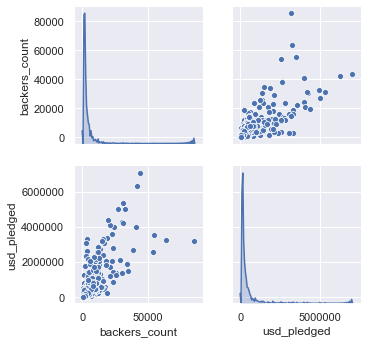

In [122]:
sns.pairplot(ks_df_1.drop('profile_project_id', axis =1), diag_kind='kde')

In [141]:
X1 = ks_df_1['backers_count'].values.reshape(-1, 1)
y1 = ks_df_1['usd_pledged']
model(X1, y1, one_x = True)

Best possible Linear Regression R^2: 0.6386666096751008
K-Fold CV Linear Regression R^2: [0.66495969 0.59436342 0.67824349 0.69938624 0.53004688] mean:  0.6333999436166236


## Backers count is a strong proxy for dollars raised. 
However, I don't want to use this features, as it's pretty obvious, and not information that a creator has at their disposal

# Expand model. 
Run it with a few features (3 or 4), so it is still humanly interpretable. Plot distribution of target variable, errors vs. predicted value to see if non-linearity or heteroskedasticity are an issue. Check fit of the model. Possibly run statsmodels to calculate p-values and see if they correspond to your intuition.

In [160]:
df_2 = df.copy()
df_2['staff_pick'] = (df_2['staff_pick']).astype(int)
df_2['is_flagged_spotlight'] = (df_2['is_flagged_spotlight']).astype(int)
df_2['launch_day'] = (df_2['launched_at'].dt.day_name())
df_2['deadline_day'] = (df_2['deadline'].dt.day_name())
df_2['duration'] = df_2['deadline'] - df_2['launched_at']
df_2['duration_days'] = df_2['duration'].dt.days
df_2=df_2[df_2['profile_project_id'] != 1577596]
df_2=df_2[df_2['profile_project_id'] != 2752819]
df_2.head(2)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10561 entries, 0 to 11606
Data columns (total 37 columns):
backers_count               10561 non-null int64
base_id                     10561 non-null int64
blurb                       10561 non-null object
category_id                 10561 non-null int64
category_parent_id          10561 non-null int64
category_slug               10561 non-null object
converted_pledged_amount    10561 non-null int64
country                     10561 non-null object
created_at                  10561 non-null datetime64[ns]
creator_id                  10561 non-null int64
creator_url                 10561 non-null object
deadline                    10561 non-null datetime64[ns]
fx_rate                     10561 non-null float64
goal                        10561 non-null float64
is_flagged_spotlight        10561 non-null int64
launched_at                 10561 non-null datetime64[ns]
location_country            10558 non-null object
location_id           

In [161]:
df_2[['launched_friday', 'launched_monday', 'launched_saturday','launched_sunday', 
    'launched_thursday', 'launched_tuesday', 'launched_wednesday'
   ]] = pd.get_dummies(df_2['launch_day'],drop_first=False)


In [162]:
df_2[['deadline_friday', 'deadline_monday', 'deadline_saturday','deadline_sunday', 
    'deadline_thursday', 'deadline_tuesday', 'deadline_wednesday'
   ]] = pd.get_dummies(df_2['deadline_day'],drop_first=False)


In [163]:
ks_df_2 = df_2[[
#     'launched_monday',
#     'launched_tuesday',
#     'launched_wednesday', 
#     'launched_thursday', 
#     'launched_friday', 
#     'launched_saturday', 
#     'launched_sunday',
#     'deadline_monday',
#     'deadline_tuesday',
#     'deadline_wednesday', 
#     'deadline_thursday', 
#     'deadline_friday', 
#     'deadline_saturday', 
#     'deadline_sunday',
#   'backers_count',
     'staff_pick',
     'goal',
     'duration_days',    
    'usd_pledged'
   ]].dropna()
ks_df_2.sample(3)
pledged
# for categorical, check if there's a cutoff off frequency and combine into other
# look into regularization


,staff_pick,goal,duration_days,usd_pledged
2670,0,6000.0,30,21272.000000
8053,1,10000.0,23,166887.635265
8116,1,30000.0,35,69229.443317


In [164]:
ks_df_2.corr() # not as good as backer count

,staff_pick,goal,duration_days,usd_pledged
staff_pick,1.000000,0.143430,0.057274,0.268999
goal,0.143430,1.000000,0.046888,0.246713
duration_days,0.057274,0.046888,1.000000,0.001898
usd_pledged,0.268999,0.246713,0.001898,1.000000


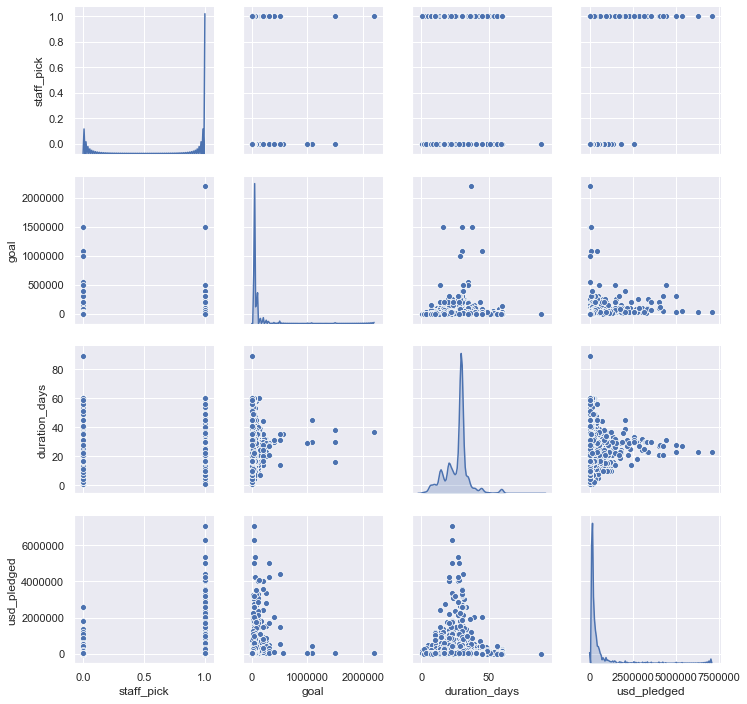

In [166]:
sns.pairplot(ks_df_2, diag_kind='kde')

In [168]:
# These are all successful, projects so pledged must always be >= goal,
#  unless i'm not properly accounting for currency
ks_df_2[ks_df_2['usd_pledged'] < ks_df_2['goal']]

,staff_pick,goal,duration_days,usd_pledged
32,0,10000.0,30,9377.874146
48,0,100000.0,12,1707.616814
86,0,20000.0,35,18376.383253
110,0,100000.0,12,2858.378512
162,0,8000.0,30,7760.421893
240,0,20000.0,35,17313.623184
247,0,900.0,30,203.028828
310,0,22222.0,31,3985.120340
313,0,5000.0,30,3943.399192
346,0,15673.0,28,7144.632290


In [169]:
ks_df_3 = df_2[[
#     'launched_monday',
#     'launched_tuesday',
#     'launched_wednesday', 
#     'launched_thursday', 
#     'launched_friday', 
#     'launched_saturday', 
#     'launched_sunday',
#     'deadline_monday',
#     'deadline_tuesday',
#     'deadline_wednesday', 
#     'deadline_thursday', 
#     'deadline_friday', 
#     'deadline_saturday', 
#     'deadline_sunday',
#   'backers_count',
    'pledged',
    'fx_rate',
    'country',
    'staff_pick',
    'goal',
    'duration_days',    
    'usd_pledged'
   ]].dropna()
ks_df_3.sample(3)

,pledged,fx_rate,country,staff_pick,goal,duration_days,usd_pledged
8038,115006.0,1.0,US,0,30000.0,45,115006.0
6974,5089.0,1.0,US,0,1000.0,30,5089.0
1052,10211.0,1.0,US,0,500.0,11,10211.0


In [171]:
ks_df_3[ks_df_3['usd_pledged'] < ks_df_3['goal']]

,pledged,fx_rate,country,staff_pick,goal,duration_days,usd_pledged
32,13055.52,0.674564,AU,0,10000.0,30,9377.874146
48,188959.00,0.009313,JP,0,100000.0,12,1707.616814
86,24175.29,0.752136,CA,0,20000.0,35,18376.383253
110,304700.00,0.009313,JP,0,100000.0,12,2858.378512
162,11124.72,0.674564,AU,0,8000.0,30,7760.421893
240,23073.00,0.752136,CA,0,20000.0,35,17313.623184
247,1729.00,0.100932,SE,0,900.0,30,203.028828
310,27210.66,0.146933,DK,0,22222.0,31,3985.120340
313,5414.50,0.674564,AU,0,5000.0,30,3943.399192
346,56060.00,0.127493,HK,0,15673.0,28,7144.632290


In [179]:
# this is not perfect, but it converts the goal into USD using the ration between USD_pledged and pledged (in local currency)

ks_df_3['usd_goal'] = ks_df_3['goal'] *  (ks_df_3['usd_pledged'] / ks_df_3['pledged'])


In [181]:

ks_df_3[ks_df_3['usd_pledged'] < ks_df_3['usd_goal']]

,pledged,fx_rate,country,staff_pick,goal,duration_days,usd_pledged,fx_conv_goal,check_pledged,usd_goal


In [186]:
ks_df_3[(ks_df_3['country'] == 'US') & (ks_df_3['usd_goal'] != ks_df_3['goal'])]

,pledged,fx_rate,country,staff_pick,goal,duration_days,usd_pledged,fx_conv_goal,check_pledged,usd_goal


### Now we can use usd_goal which scales properly to to usd_pledged, and gives us a consistent unit for pledged & goal amounts

In [189]:
ks_df_3.corr() # usd_goal correlates better to usd_pledged than goal

,pledged,fx_rate,staff_pick,goal,duration_days,usd_pledged,usd_goal
pledged,1.000000,-0.164732,0.258192,0.534061,0.008421,0.879754,0.487743
fx_rate,-0.164732,1.000000,-0.027015,-0.265702,-0.069806,0.012797,0.007541
staff_pick,0.258192,-0.027015,1.000000,0.143430,0.057274,0.268999,0.267308
goal,0.534061,-0.265702,0.143430,1.000000,0.046888,0.246713,0.474729
duration_days,0.008421,-0.069806,0.057274,0.046888,1.000000,0.001898,0.063084
usd_pledged,0.879754,0.012797,0.268999,0.246713,0.001898,1.000000,0.537396
usd_goal,0.487743,0.007541,0.267308,0.474729,0.063084,0.537396,1.000000


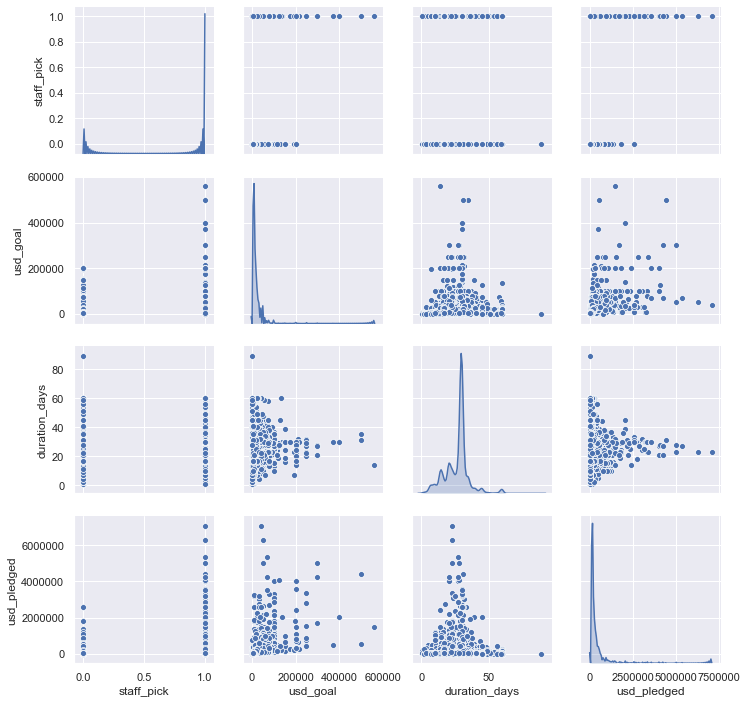

In [193]:
sns.pairplot(ks_df_3[['staff_pick','usd_goal','duration_days', 'usd_pledged']], diag_kind='kde')

In [194]:
X2 = ks_df_3[['staff_pick','usd_goal','duration_days']]
y2 = ks_df_3['usd_pledged']
model(X2, y2)

Best possible Linear Regression R^2: 0.28610115575991313
K-Fold CV Linear Regression R^2: [0.18105083 0.40607935 0.26230224 0.25442309 0.30681262] mean:  0.2821336248731834
Best possible Ridge Regression R^2: 0.2861011519955379
K-fold CV Ridge Regression R^2:  [0.18107854 0.40605431 0.26230738 0.25450109 0.30678893] mean:  0.28214605079024474
Best possible Polynomial Regression R^2: 0.35422579620809674
K-fold CV Polynomial Regression R^2:  0.33775321570268846 mean:  0.33775321570268846


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
       random_state=None, solver='auto', tol=0.001),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

# Add Board game geek data

In [30]:
bgg_df = pd.read_pickle('../resources/pickles/bgg.pkl')

In [31]:
bgg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198 entries, 0 to 1197
Data columns (total 32 columns):
bgg_average_rating           1198 non-null float64
bgg_avg_complex_weight       770 non-null float64
bgg_categories               963 non-null object
bgg_categories_count         976 non-null float64
bgg_category                 222 non-null object
bgg_expansions               976 non-null float64
bgg_families                 793 non-null object
bgg_families_count           976 non-null float64
bgg_genre                    222 non-null object
bgg_integrations             976 non-null float64
bgg_is_compilation           976 non-null float64
bgg_is_reimplementation      976 non-null float64
bgg_mechanics                1138 non-null object
bgg_mechanics_count          1198 non-null int64
bgg_poll_best_age            528 non-null object
bgg_poll_best_num_players    629 non-null object
bgg_prod_team_size           1198 non-null int64
bgg_rpg_id                   222 non-null object
b

In [32]:
rpg_df = bgg_df[bgg_df['bgg_type'] == 'rpgitem']
bg_df = bgg_df[bgg_df['bgg_type'] == 'boardgame']

In [33]:
ks_bg = bg_df.merge(df, how='left', left_on='profile_project_id', right_on='profile_project_id')

In [34]:
ks_bg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 0 to 969
Data columns (total 82 columns):
bgg_average_rating           970 non-null float64
bgg_avg_complex_weight       735 non-null float64
bgg_categories               957 non-null object
bgg_categories_count         970 non-null float64
bgg_category                 0 non-null object
bgg_expansions               970 non-null float64
bgg_families                 788 non-null object
bgg_families_count           970 non-null float64
bgg_genre                    0 non-null object
bgg_integrations             970 non-null float64
bgg_is_compilation           970 non-null float64
bgg_is_reimplementation      970 non-null float64
bgg_mechanics                928 non-null object
bgg_mechanics_count          970 non-null int64
bgg_poll_best_age            525 non-null object
bgg_poll_best_num_players    625 non-null object
bgg_prod_team_size           970 non-null int64
bgg_rpg_id                   0 non-null object
bgg_rpg_val  

2.086372517006803

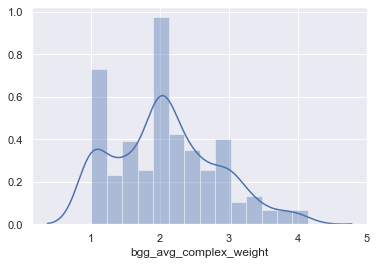

In [38]:
sns.distplot(ks_bg['bgg_avg_complex_weight'].dropna())
ks_bg['bgg_avg_complex_weight'].dropna().mean()

# y = USD Pledged

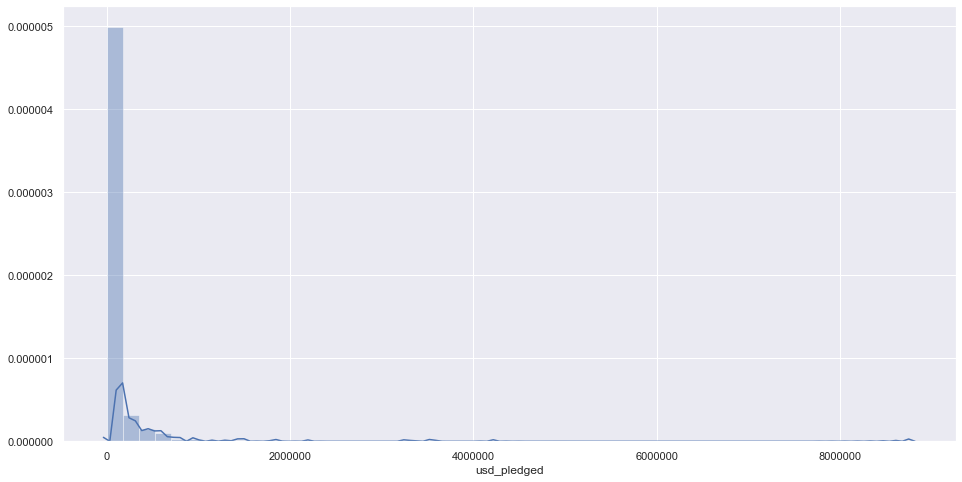

In [79]:
plt.figure(figsize=(16,8))
sns.distplot(ks_bg['usd_pledged'])

In [80]:
ks_bg['usd_pledged'].describe()

count    9.700000e+02
mean     1.148025e+05
std      4.251864e+05
min      1.430000e+02
25%      9.900915e+03
50%      2.407092e+04
75%      7.020829e+04
max      8.782572e+06
Name: usd_pledged, dtype: float64

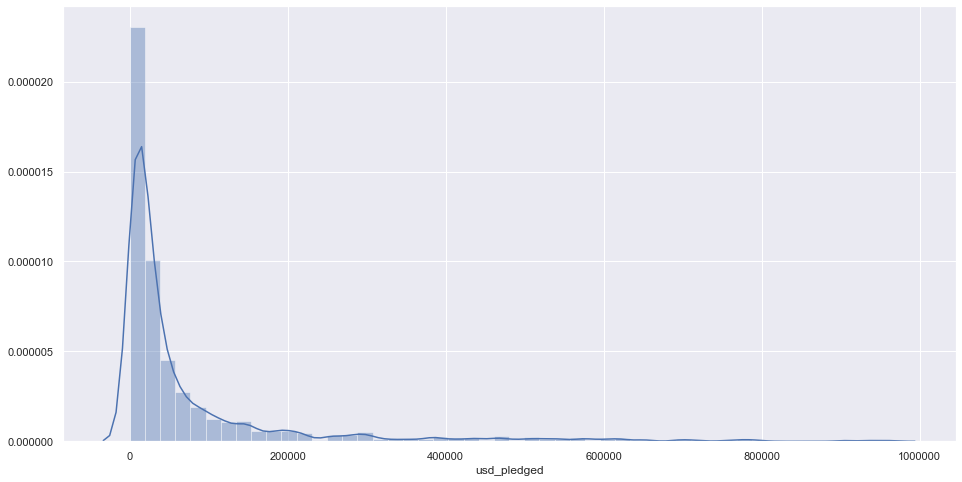

In [82]:
plt.figure(figsize=(16,8))
sns.distplot(ks_bg[ks_bg['usd_pledged'] < 1000000]['usd_pledged'])


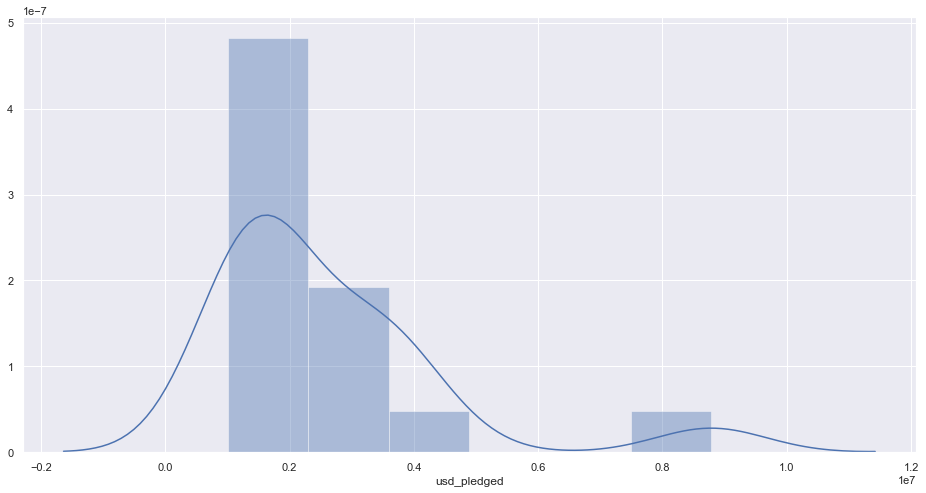

In [83]:
plt.figure(figsize=(16,8))
sns.distplot(ks_bg[ks_bg['usd_pledged'] >= 1000000]['usd_pledged'])

In [204]:
ks_bg.sort_values(by='usd_pledged', ascending=False).head(20)

,bgg_average_rating,bgg_avg_complex_weight,bgg_categories,bgg_categories_count,bgg_category,bgg_expansions,bgg_families,bgg_families_count,bgg_genre,bgg_integrations,bgg_is_compilation,bgg_is_reimplementation,bgg_mechanics,bgg_mechanics_count,bgg_poll_best_age,bgg_poll_best_num_players,bgg_prod_team_size,bgg_rpg_id,bgg_rpg_val,bgg_series,bgg_seriescode,bgg_setting,bgg_thing_id,bgg_type,bgg_users_rated,max_players,max_playtime,min_age,min_players,min_playtime,playingtime,profile_project_id,backers_count,base_id,blurb,category_id,category_parent_id,category_slug,converted_pledged_amount,country,created_at,creator_id,creator_url,deadline,fx_rate,goal,is_flagged_spotlight,launched_at,location_country,location_id,location_name,name,percent_funded,pledged,profile_external_url,profile_state,profile_state_changed_at,slug,staff_pick,state,state_changed_at,url_project,url_rewards,usd_pledged,launch_day,deadline_day,duration,duration_days,launched_friday,launched_monday,launched_saturday,launched_sunday,launched_thursday,launched_tuesday,launched_wednesday,deadline_friday,deadline_monday,deadline_saturday,deadline_sunday,deadline_thursday,deadline_tuesday,deadline_wednesday
820,5.96810,1.0757,"bg_cat Animals,bg_cat Card Game,bg_cat Comic B...",4.0,NaN,4.0,"bg_fam Animals: Cats,bg_fam Card Games: Matchi...",3.0,NaN,1.0,0.0,1.0,"bg_mec Hand Management,bg_mec Player Eliminati...",5,8,4,17,NaN,NaN,NaN,NaN,NaN,172225,boardgame,15262,5,15,7,2,15,15,1577596,219382,1955357092,This is a card game for people who are into ki...,34,12,games/tabletop games,8782571,US,2014-12-15 08:39:54,1281334714,https://www.kickstarter.com/profile/elanlee,2015-02-20 02:00:00,1.000000,10000.0,True,2015-01-20 18:00:19,United States,2442047.0,"Los Angeles, CA",Exploding Kittens,87825.719900,8782571.99,https://www.kickstarter.com/projects/elanlee/t...,active,2015-03-28 22:11:30,exploding-kittens,1,successful,2015-02-20 02:01:19,https://www.kickstarter.com/projects/elanlee/e...,https://www.kickstarter.com/projects/elanlee/e...,8.782572e+06,Tuesday,Friday,30 days 07:59:41,30,0,0,0,0,0,1,0,1,0,0,0,0,0,0
608,7.96616,3.2723,"bg_cat Bluffing,bg_cat Fantasy,bg_cat Miniatur...",6.0,NaN,6.0,"bg_fam Admin: Better Description Needed!,bg_fa...",7.0,NaN,0.0,0.0,0.0,"bg_mec Area Majority / Influence,bg_mec Area M...",7,14,4,14,NaN,NaN,NaN,NaN,NaN,205896,boardgame,11940,5,120,14,3,90,120,2892230,31262,419246523,"Clans must use politics, strength and honor to...",34,12,games/tabletop games,4228060,US,2017-02-23 22:28:11,1134494596,https://www.kickstarter.com/profile/cmon,2017-04-04 04:00:00,1.000000,300000.0,True,2017-03-07 20:04:15,United States,2357024.0,"Atlanta, GA",Rising Sun,1409.353333,4228060.00,https://www.facebook.com/risingsunboardgame/,active,2017-04-04 04:02:18,rising-sun,1,successful,2017-04-04 04:00:00,https://www.kickstarter.com/projects/cmon/risi...,https://www.kickstarter.com/projects/cmon/risi...,4.228060e+06,Tuesday,Tuesday,27 days 07:55:45,27,0,0,0,0,0,1,0,0,0,0,0,0,1,0
804,7.35269,2.5370,"bg_cat Adventure,bg_cat Exploration,bg_cat Fan...",5.0,NaN,13.0,"bg_fam Admin: Better Description Needed!,bg_fa...",5.0,NaN,0.0,0.0,0.0,"bg_mec Action Points,bg_mec Cooperative Game,b...",6,10,3,9,NaN,NaN,NaN,NaN,NaN,197070,boardgame,3263,6,180,14,1,90,180,2539033,22361,132311747,A dungeon crawl board game with no game master...,34,12,games/tabletop games,3560642,US,2016-05-31 03:40:25,1134494596,https://www.kickstarter.com/profile/cmon,2016-07-07 23:00:00,1.000000,200000.0,True,2016-06-07 19:02:31,United States,2357024.0,"Atlanta, GA",Massive Darkness,1780.321330,3560642.66,https://www.facebook.com/GuillotineGames/,active,2016-07-07 23:05:04,massive-darkness,1,successful,2016-07-07 23:00:00,https://www.kickstarter.com/projects/cmon/mass...,https://www.kickstarter.com/projects/cmon/mass...,3.560643e+06,Tuesday,Thursday,30 days 03:57:29,30,0,0,0,0,0,1,0,0,0,0,0,1,0,0
175,6.66667,1.0000,bg_cat Party Game,1.0,NaN,0.0,"bg_fam Admin: Unreleased Games,bg_fam Crowdfun...",2.0,NaN,0.0,0

In [1]:
ks_bg.groupby('bgg_categories').count()

NameError: name 'ks_bg' is not defined

In [206]:
small_df = ks_bg[[
#     'launched_monday',
#     'launched_tuesday',
#     'launched_wednesday', 
#     'launched_thursday', 
#     'launched_friday', 
#     'launched_saturday', 
#     'launched_sunday',
#     'deadline_monday',
#     'deadline_tuesday',
#     'deadline_wednesday', 
#     'deadline_thursday', 
#     'deadline_friday', 
#     'deadline_saturday', 
#     'deadline_sunday',
    'staff_pick',
    
    'goal',
    'bgg_average_rating',
    'bgg_categories_count',
    'bgg_mechanics_count',
    'bgg_prod_team_size',
    'duration_days',
    'bgg_avg_complex_weight',
    
    'usd_pledged'
   ]].dropna()
small_df.sample(3)



# for categorical, check if there's a cutoff off frequency and combine into other
# look into regularization


,staff_pick,goal,bgg_average_rating,bgg_categories_count,bgg_mechanics_count,bgg_prod_team_size,duration_days,bgg_avg_complex_weight,usd_pledged
554,1,500000.0,6.66087,4.0,6,7,35,2.7708,518538.380000
424,0,5000.0,6.72935,2.0,2,7,25,1.8000,7481.991953
642,0,22222.0,6.08571,2.0,3,3,31,1.5000,3985.120340


In [207]:
smaller_df = small_df[small_df['usd_pledged'] < 1000000]
smaller_df

,staff_pick,goal,bgg_average_rating,bgg_categories_count,bgg_mechanics_count,bgg_prod_team_size,duration_days,bgg_avg_complex_weight,usd_pledged
0,1,35000.0,6.64623,3.0,5,2,29,2.9333,52518.695419
1,0,500.0,5.49312,3.0,2,4,30,1.5000,8327.650000
2,1,20000.0,7.04886,1.0,2,3,30,2.0000,60410.000000
3,0,45000.0,8.38750,6.0,5,4,28,2.6000,181758.936128
4,0,5000.0,8.12500,4.0,2,3,30,1.0000,5720.000000
5,0,12000.0,6.95803,2.0,4,3,28,1.7895,16281.000000
6,0,35000.0,6.63462,2.0,1,5,20,2.0000,62187.293983
8,0,1000.0,6.35143,3.0,4,2,30,2.0000,2384.000000
11,0,35000.0,8.85000,3.0,8,2,30,2.0000,53174.825459
12,1,25000.0,7.09133,3.0,3,3,30,2.6667,26482.000000


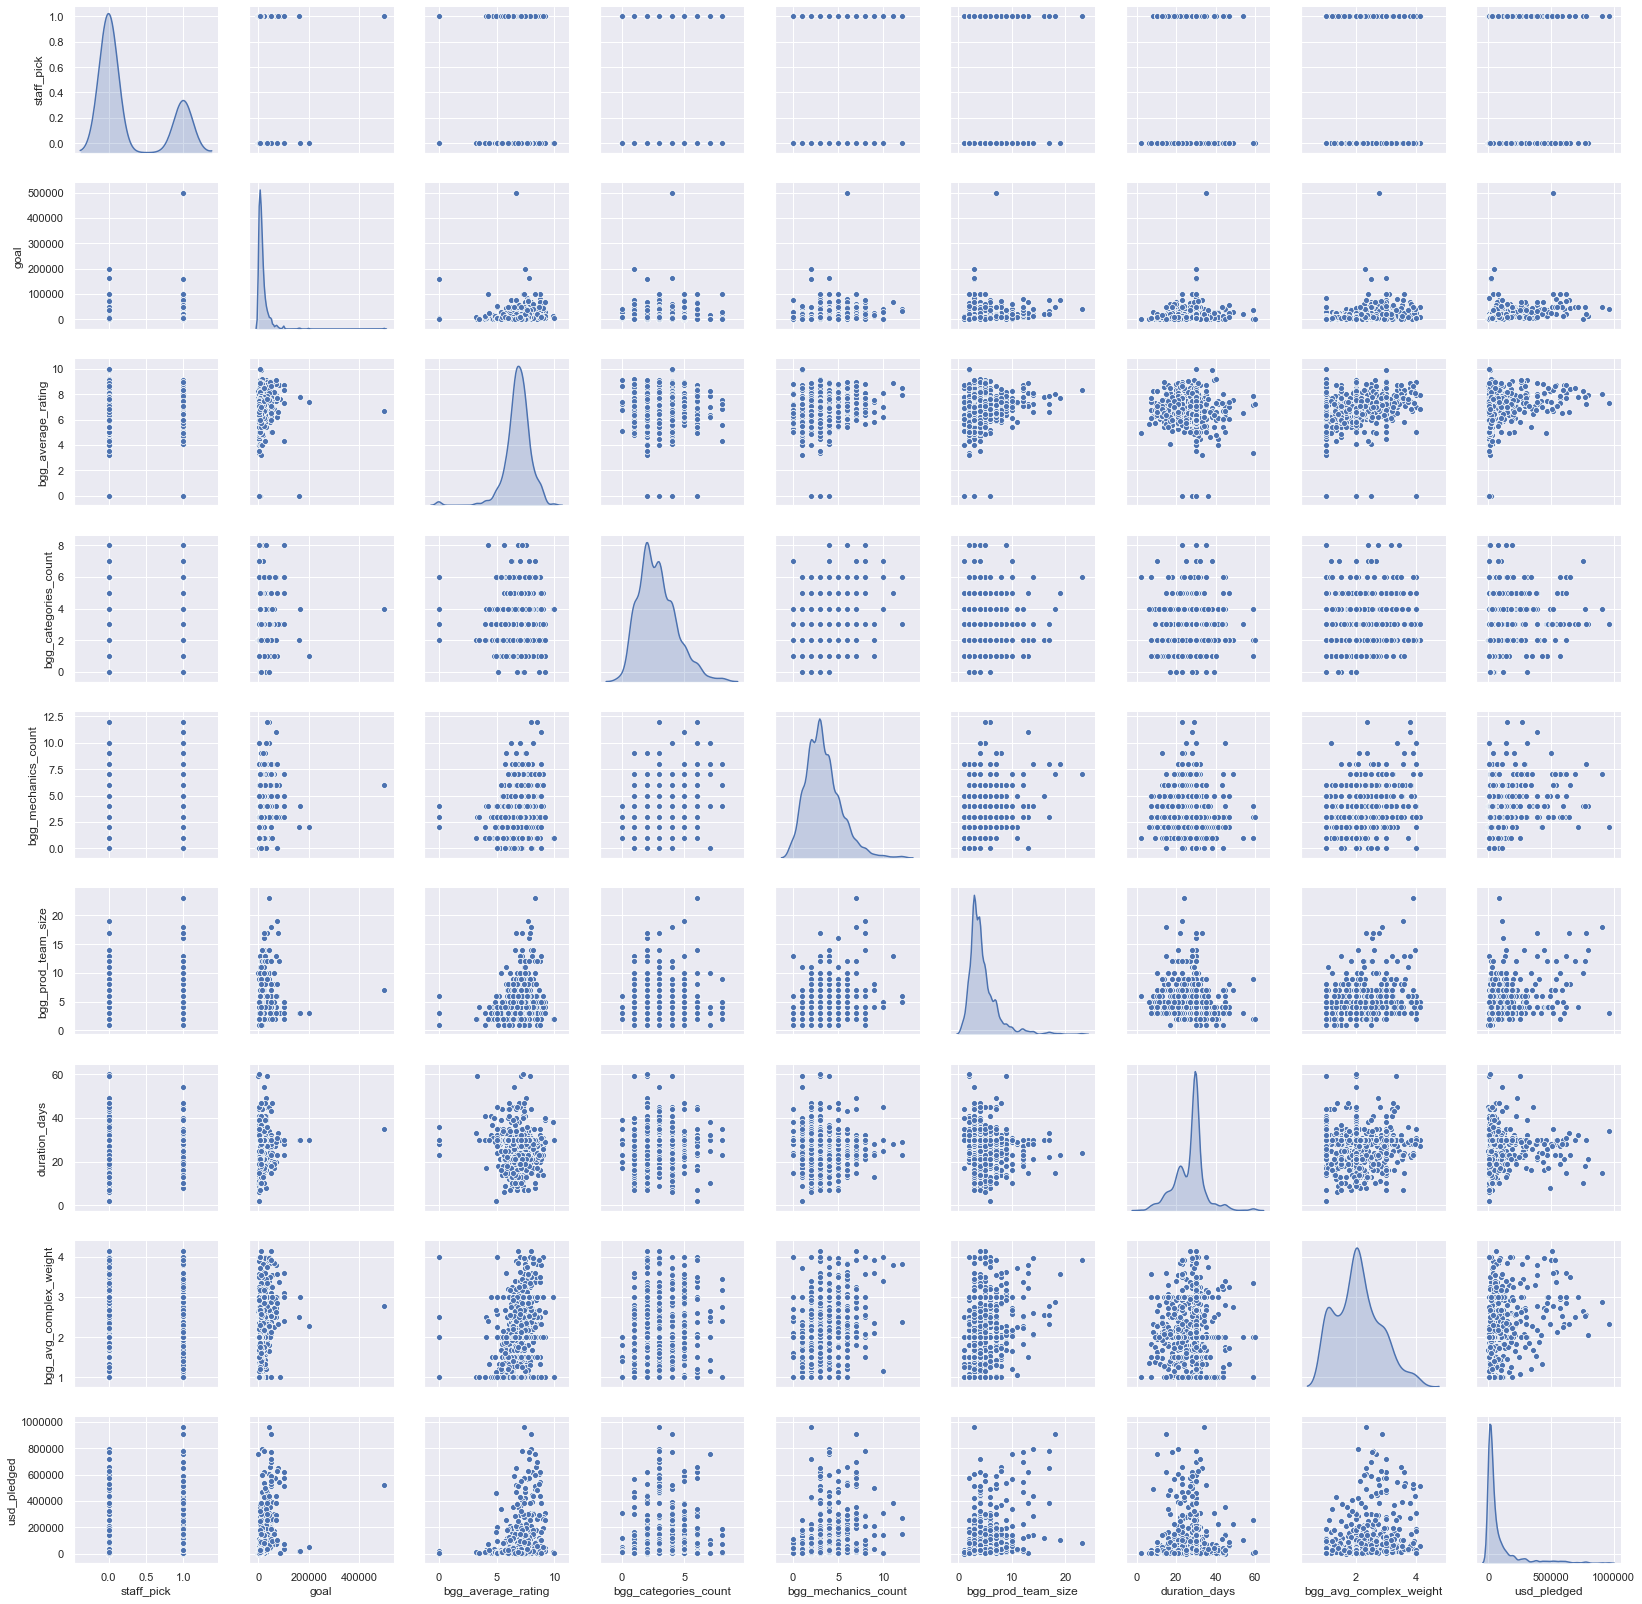

In [208]:
sns.pairplot(smaller_df, diag_kind='kde')

In [209]:
X = smaller_df.drop(['usd_pledged'], axis=1)
y = smaller_df['usd_pledged']

# Modeling

In [ ]:
X_train, X_val, y, y_val = train_test_split(X, y, test_size=0.25)

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_val, y_val))

In [ ]:
poly = PolynomialFeatures()

X_train = poly.fit_transform(X_train)
X_val = poly.fit_transform(X_val)
X_test = poly.transform(X_test)

# Cross Validation

In [19]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.25)

# Linear
# score on train to get upper bound
lm = LinearRegression()
lm.fit(X_cv, y_cv)
print("Best possible Linear Regression R^2:", lm.score(X_cv, y_cv))

lm = LinearRegression()
cv_scores = cross_val_score(lm, X_cv, y_cv, # estimator, features, target
                              cv=5, # number of folds 
                              scoring='r2') # scoring metric

print('K-Fold CV Linear Regression R^2:',  cv_scores, "mean: ", np.mean(cv_scores))
lm.fit(X_cv,y_cv)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

# Poly
lm_poly = LinearRegression()
print('K fold Polynomial Regression R^2: ', 
      np.mean(cross_val_score(lm, X, y, # estimator, features, target
                              cv=5, # number of folds 
                              scoring='r2'))) # scoring metric


NameError: name 'X' is not defined

K-Fold CV Linear Regression R^2: [0.28135917 0.44234261 0.29636856 0.25983104 0.1674714 ] mean:  0.2894745579692221
Linear Regression test R^2: 0.240


In [ ]:
lm_poly = LinearRegression()
print('K fold Polynomial Regression R^2: ', 
      np.mean(cross_val_score(lm, X, y, # estimator, features, target
                              cv=5, # number of folds 
                              scoring='r2'))) # scoring metric

In [72]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [73]:
m = sm.OLS(y,X)
fit = m.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            usd_pledged   R-squared (uncentered):                   0.228
Model:                            OLS   Adj. R-squared (uncentered):              0.222
Method:                 Least Squares   F-statistic:                              35.90
Date:                Thu, 10 Oct 2019   Prob (F-statistic):                    3.72e-38
Time:                        13:18:12   Log-Likelihood:                         -10596.
No. Observations:                 735   AIC:                                  2.120e+04
Df Residuals:                     729   BIC:                                  2.123e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
goal                       5.1365      0.577      8.907      0.000       4.004       6.269
bgg_average_rating      8849.6155   1.01e+04      0.875      0.382    -1.1e+04    2.87e+04
bgg_categories_count    2.729e+04   1.12e+04      2.447      0.015    5395.319    4.92e+04
staff_pick              1.695e+05   3.69e+04      4.597      0.000    9.71e+04    2.42e+05
duration_days          -3278.1540   1874.361     -1.749      0.081   -6957.944     401.636
bgg_avg_complex_weight -2.471e+04    2.4e+04     -1.028      0.304   -7.19e+04    2.25e+04
==============================================================================
Omnibus:                     1305.416   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1224146.823
Skew:                          11.484   Prob(JB):                         0.00
Kurtosis:                     201.607   Cond. No.                     8.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# y = percent_funded